# Dimensionality Reduction on MNIST: PCA & t-SNE

In [1]:
# Ideally would put in a Sherlock environment 
!sudo apt-get -y install libopenblas-dev liblapack-dev
!sudo apt-get -y install libatlas-base-dev
!pip install git+https://github.com/alexisbcook/tsne.git
# !wget http://deeplearning.net/data/mnist/mnist.pkl.gz
!pip install hdbscan

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  gfortran gfortran-5 libblas-common libblas-dev libblas3 libgfortran-5-dev
  libgfortran3 liblapack3 libopenblas-base
Suggested packages:
  gfortran-multilib gfortran-doc gfortran-5-multilib gfortran-5-doc
  libgfortran3-dbg liblapack-doc-man liblapack-doc
The following NEW packages will be installed:
  gfortran gfortran-5 libblas-common libblas-dev libblas3 libgfortran-5-dev
  libgfortran3 liblapack-dev liblapack3 libopenblas-base libopenblas-dev
0 upgraded, 11 newly installed, 0 to remove and 0 not upgraded.
Need to get 21.3 MB of archives.
After this operation, 136 MB of additional disk space will be used.
Get:1 http://eu-west-1.ec2.archive.ubuntu.com/ubuntu xenial-updates/main amd64 libgfortran3 amd64 5.4.0-6ubuntu1~16.04.5 [260 kB]
Get:2 http://eu-west-1.ec2.archive.ubuntu.com/ubuntu xenial-updates/main amd64 libgfortran-5-dev amd64 

  Running setup.py install for tsne.bh-sne ... done
    100% |████████████████████████████████| 5.1MB 177kB/s eta 0:00:01
  Running setup.py bdist_wheel for hdbscan ... done
  Stored in directory: /home/sherlock/.cache/pip/wheels/2e/8a/87/4275d3647416bf4267ff4483a7046f4d736223b3f071fd71ff
Successfully built hdbscan


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import gzip, pickle

from sklearn.cluster import KMeans
import hdbscan
from sklearn.decomposition import PCA
from tsne import bh_sne

import seaborn as sns
palette = np.array(sns.color_palette("hls", 11))

%matplotlib inline  

The famous MNIST dataset is a collection of images of hand-written digits. A classic problem and now benchmmark for models in machine learning is whether it is possible to train a classifier to distinguish between these different digits. The MNIST dataset is actually labelled and so is appropriate for supervised learning but here we'll look at the extent to which purely unsupervised methods are able to segment it. In other words, we will only use the labels to check how well we've done at the end of the calculation. Each digit is represented as a (28x28) array of pixels and the dataset contains 70,000 images. 

In [3]:
f = gzip.open("mnist.pkl.gz", "rb")
train, val, test = pickle.load(f, encoding='latin1')
f.close()

In [4]:
X = np.asarray(np.vstack((train[0], val[0], test[0])), dtype=np.float64)
y = np.hstack((train[1], val[1], test[1]))

In [5]:
feat_cols = ['pixel'+ str(i) for i in range(X.shape[1])]
df = pd.DataFrame(X,columns=feat_cols)
df['label'] = y.astype(int)

It is instructive to view the first few of these MNIST digits. The function below plots the first thirty:

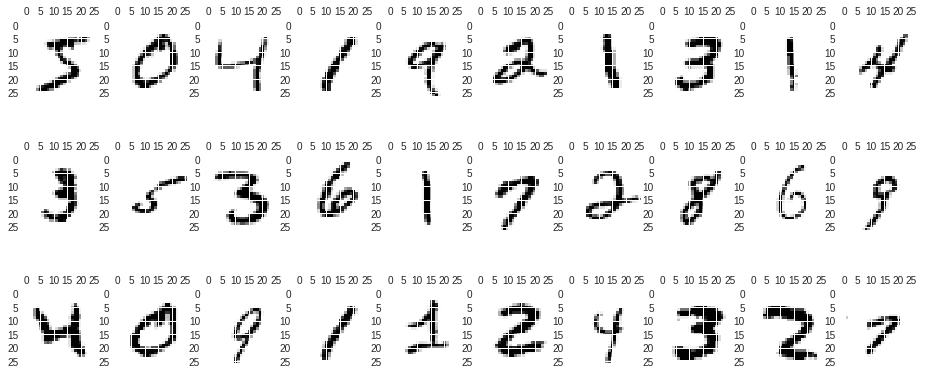

In [6]:
fig = plt.figure( figsize=(16,7) )
for i in range(0,30):
    ax = fig.add_subplot(3,10,i+1)
    ax.matshow(df.loc[i,feat_cols].values.reshape((28,28)).astype(float))
plt.show()

### 1. Principal Component Analysis (PCA)

In [7]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df.loc[:, feat_cols])

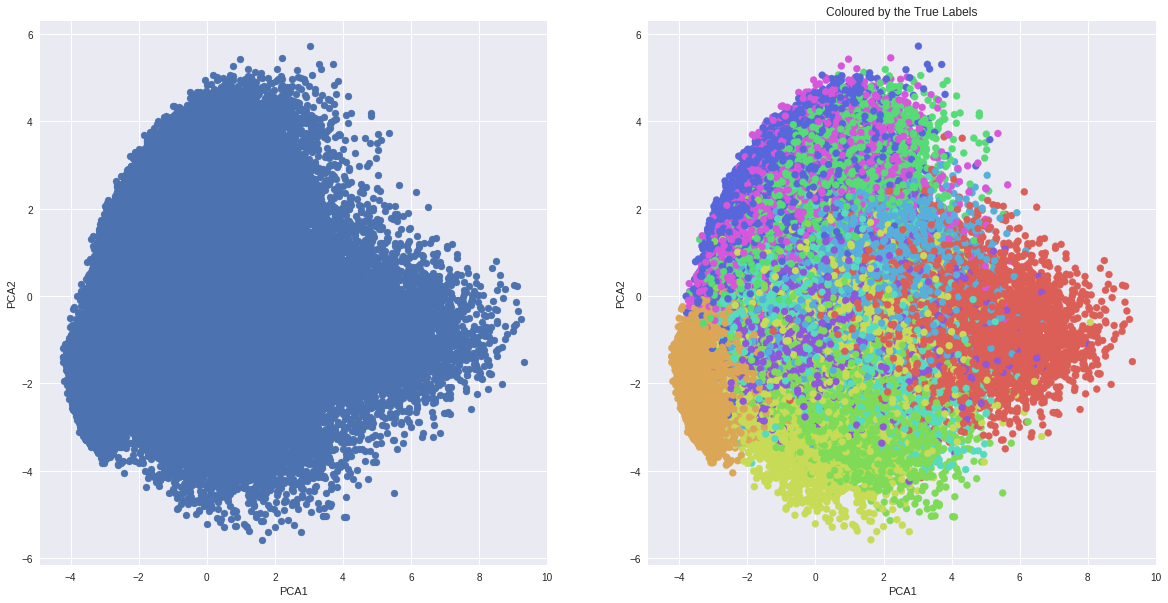

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.scatter(pca_result[:,0], pca_result[:,1])
ax2.scatter(pca_result[:,0], pca_result[:,1], c=palette[df['label'].astype(np.int)])
ax1.set_xlabel('PCA1')
ax1.set_ylabel('PCA2')
ax2.set_xlabel('PCA1')
ax2.set_ylabel('PCA2')
ax2.set_title('Coloured by the True Labels')

### 2. K-means clustering of PCA results

In [31]:
clf = KMeans(n_clusters = 10, init='k-means++', random_state = 42)
clf.fit(pca_result)
indices= clf.labels_
df['pca label'] = indices

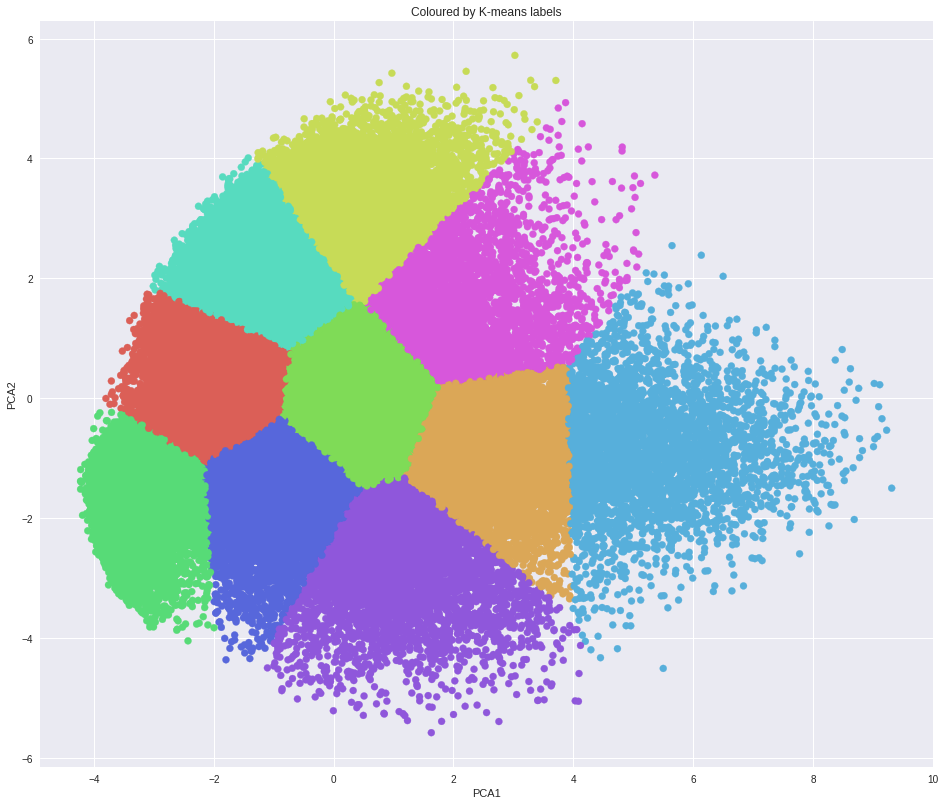

In [32]:
f = plt.figure(figsize=(16, 16))
ax = plt.subplot(aspect='equal')
sc = ax.scatter( pca_result[:,0], pca_result[:,1], c=palette[indices.astype(np.int)] )
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_title('Coloured by K-means labels')

We now group the dataframe by cluster label. We will attempt to eyeball features within each cluster in order to assign a true digit label to each cluster. We can do this by plotting a sample of images from each clusters and looking at what digits actually appear (remember the pixel values are the features and we are allowed to use these - just not the true labels). You can experiment with this, varying cluster_number from 0-9 and trying to assign a label to each of the 10 clusters.

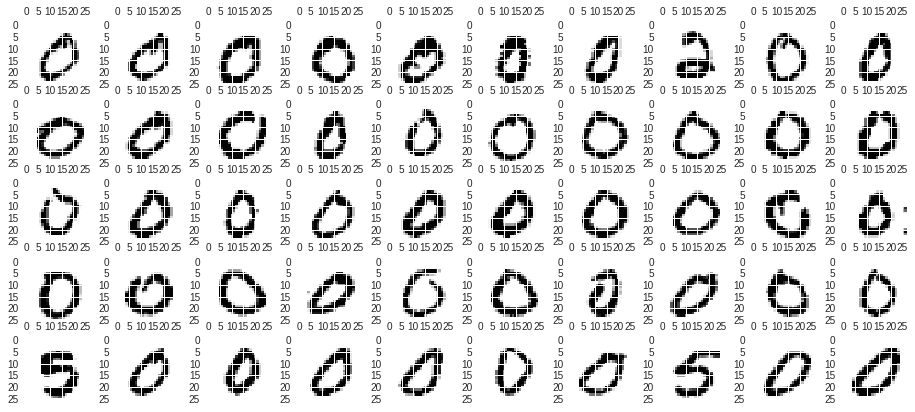

In [33]:
dict_of_clusters = {k: v for k, v in df.groupby('pca label')}

cluster_number = 6
fig = plt.figure( figsize=(16,7) )
for i in range(0,50):
    ax = fig.add_subplot(5,10,i+1)
    cluster_frames = dict_of_clusters[cluster_number].loc[:, feat_cols]
    ax.matshow(cluster_frames.iloc[i].values.reshape((28,28)).astype(float))
plt.show()

In [34]:
# Eyeballed dictionary between cluster labels and the true labels  - have a go at this
true_labels_map = {0:3, 1:4, 2:6, 3:1, 4:2, 5:0, 6:5, 7:9, 8:8, 9:7} 

In [35]:
df['pca predicted'] = df.loc[:, 'pca label'].apply(lambda x: true_labels_map[x])

In [36]:
mask = (df['label']==df['pca predicted'])
accuracy = (df.loc[mask].shape[0])/(df.shape[0])
print("Percentage Accuracy of PCA + kmeans unsupervised learning = ~", 100*accuracy) # You'll get about 35% for PCA

Percentage Accuracy of PCA + kmeans unsupervised learning = ~ 2.337142857142857


### 3. t-Distributed Stochastic Neighbour Embedding (t-SNE)

Since t-SNE can be quite slow to run, we load the results from a .csv file. The code to run the algorithm is shown below (commented). The first implementation is the one found at https://github.com/alexisbcook/tsne, whilst the latter is the sklearn implementation. Note that the former seems to be faster and also more able to handle large datasets than the sklearn implementation, however it does not have a functional random_state parameter so save your output (it will not be exactly reproducible as t-SNE is not deterministic).

In [15]:
tsne_result = np.genfromtxt ('MNIST_large_tsne.csv', delimiter=",") # Generated from the bh_sne() code

In [ ]:
# Implementation from https://github.com/alexisbcook/tsne - takes of the order 20 minutes to run
# time_start = time.time()
# tsne_result = bh_sne(df.loc[:, feat_cols])
# print(  't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)  )

In [ ]:
# Implementation from sklearn - this implementation may crash on the full MNIST data (may need a subset)
# time_start = time.time()
# tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300, random_state = 42) 
# tsne_result = tsne.fit_transform(df_sample.loc[:, feat_cols]) 
# print(  't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)  )

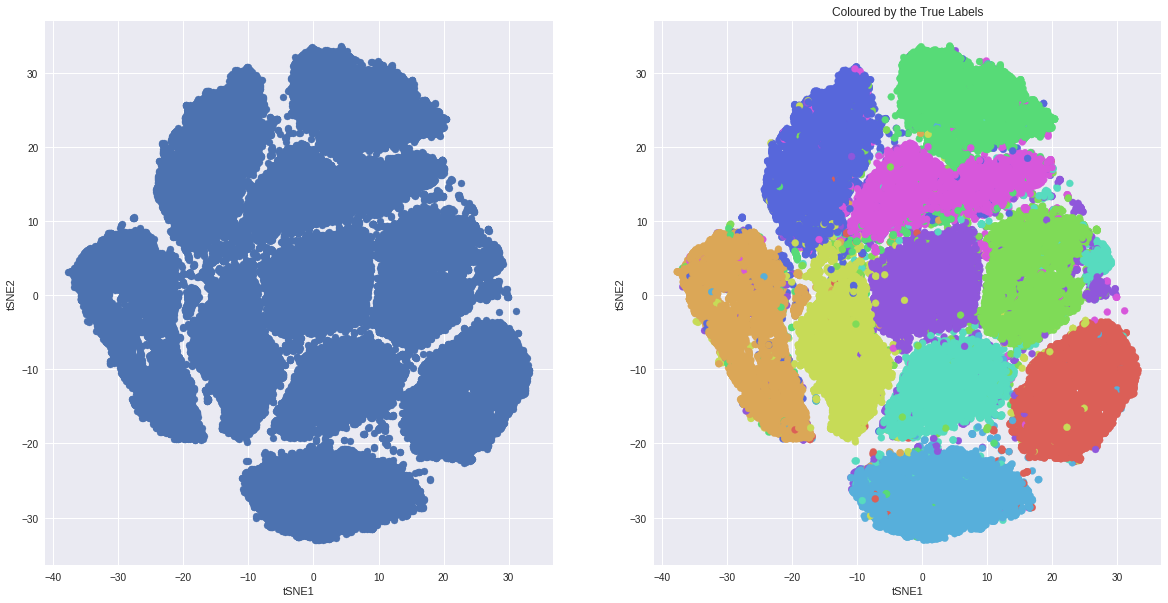

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.scatter(tsne_result[:,0], tsne_result[:,1])
ax2.scatter(tsne_result[:,0], tsne_result[:,1], c=palette[df['label'].astype(np.int)])
ax1.set_xlabel('tSNE1')
ax1.set_ylabel('tSNE2')
ax2.set_xlabel('tSNE1')
ax2.set_ylabel('tSNE2')
ax2.set_title('Coloured by the True Labels')

In [17]:
clf = KMeans(n_clusters = 10, init='k-means++', random_state = 42)
clf.fit(tsne_result)
indices= clf.labels_
df['tsne label'] = indices

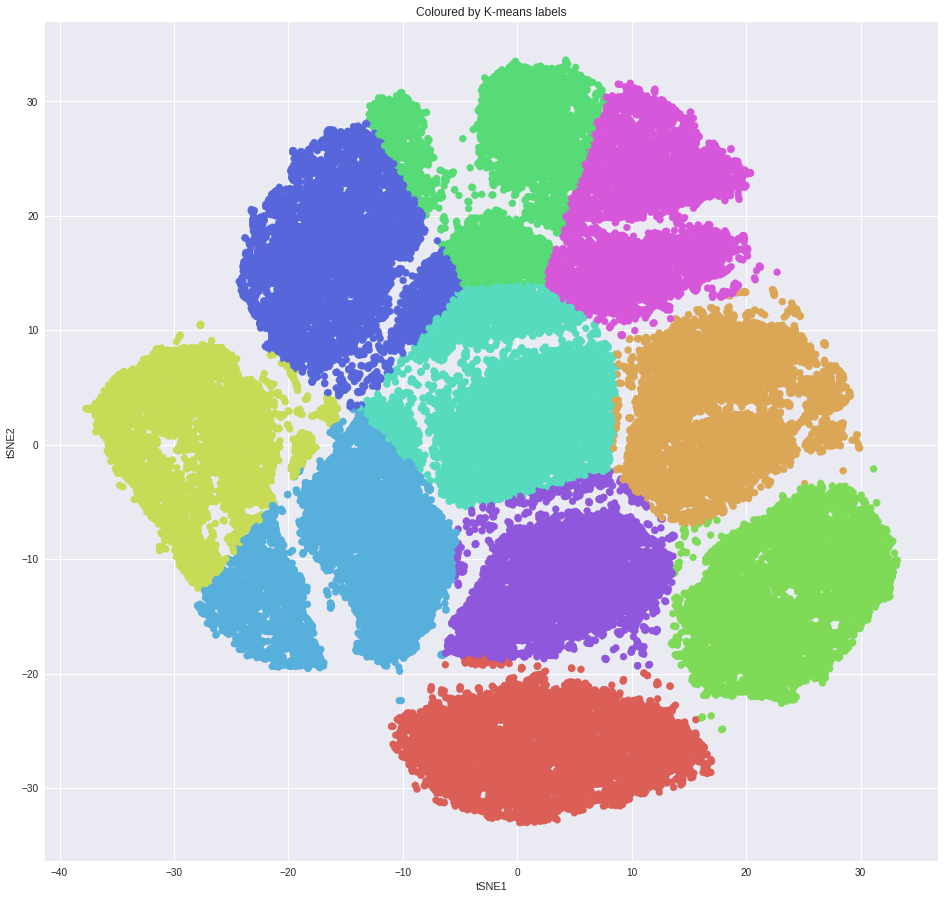

In [18]:
# Plot these results
f = plt.figure(figsize=(16, 16))
ax = plt.subplot(aspect='equal')
sc = ax.scatter( tsne_result[:,0], tsne_result[:,1], c=palette[indices.astype(np.int)] )
ax.set_xlabel('tSNE1')
ax.set_ylabel('tSNE2')
ax.set_title('Coloured by K-means labels')

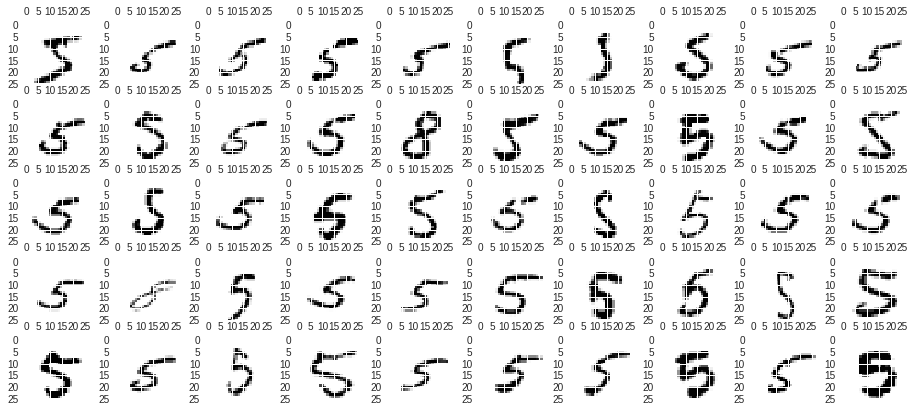

In [19]:
dict_of_clusters = {k: v for k, v in df.groupby('tsne label')}

cluster_number = 8
fig = plt.figure( figsize=(16,7) )
for i in range(0,50):
    ax = fig.add_subplot(5,10,i+1)
    cluster_frames = dict_of_clusters[cluster_number].loc[:, feat_cols]
    ax.matshow(cluster_frames.iloc[i].values.reshape((28,28)).astype(float))
plt.show()

In [20]:
true_labels_map = {0:6, 1:3, 2:1, 3:0, 4:4, 5:8, 6:2, 7:7, 8:5, 9:9}  

In [21]:
df['tsne predicted'] = df.loc[:, 'tsne label'].apply(lambda x: true_labels_map[x])

In [22]:
mask = (df['label']==df['tsne predicted'])
accuracy = (df.loc[mask].shape[0])/(df.shape[0])
print("Percentage Accuracy of tSNE + kmeans unsupervised learning = ~", 100*accuracy)

Percentage Accuracy of tSNE + kmeans unsupervised learning = ~ 79.10000000000001


### 4. Pushing the Accuracy Higher: Hierarchical DBSCAN (HDBSCAN)

In [23]:
clf = hdbscan.HDBSCAN(min_cluster_size=56)
clf.fit(tsne_result)
indices_hdbcsan = clf.labels_
df['HDBSCAN label'] = indices_hdbcsan

In [24]:
len(np.unique(indices_hdbcsan)) # DBSCAN + HDBSCAN includes 'not assigned to any cluster' as an option - hence the 11 clusters

11

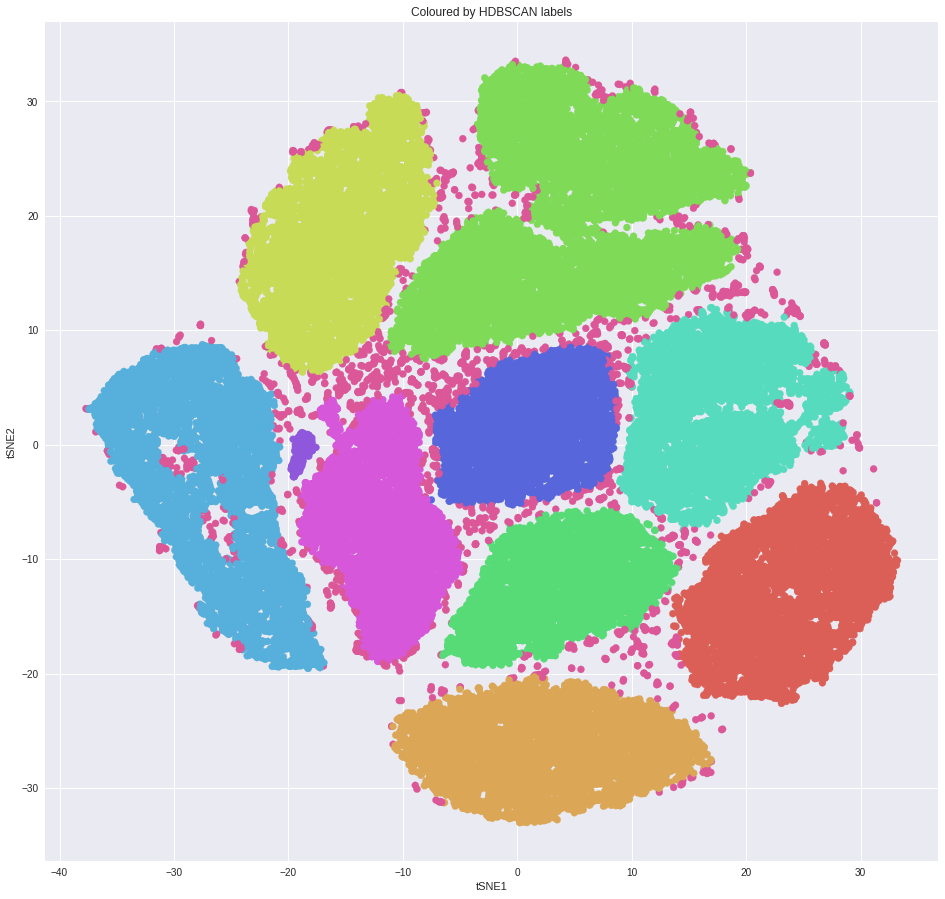

In [25]:
f = plt.figure(figsize=(16, 16))
ax = plt.subplot(aspect='equal')
sc = ax.scatter( tsne_result[:,0], tsne_result[:,1], c=palette[indices_hdbcsan.astype(np.int)] )
ax.set_xlabel('tSNE1')
ax.set_ylabel('tSNE2')
ax.set_title('Coloured by HDBSCAN labels')

In [26]:
# Drop points that do not belong to any cluster
mask = (df['HDBSCAN label'] != -1)
df_signal = df[mask]

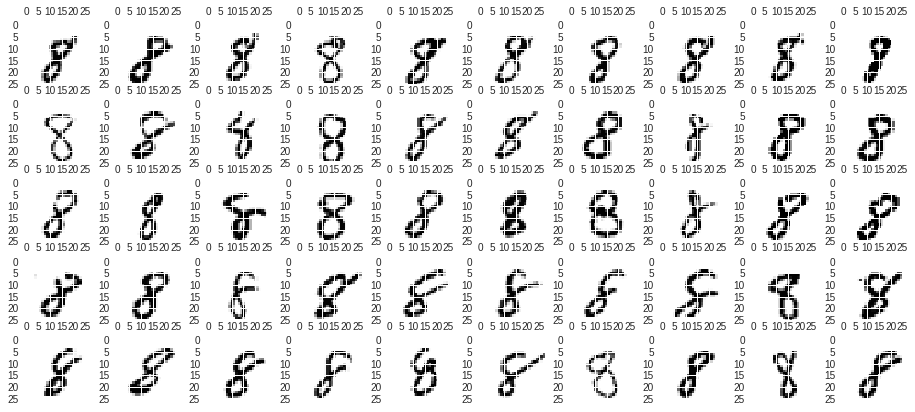

In [27]:
dict_of_clusters = {k: v for k, v in df_signal.groupby('HDBSCAN label')}

cluster_number = 7
fig = plt.figure( figsize=(16,7) )
for i in range(0,50):
    ax = fig.add_subplot(5,10,i+1)
    cluster_frames = dict_of_clusters[cluster_number].loc[:, feat_cols]
    ax.matshow(cluster_frames.iloc[i].values.reshape((28,28)).astype(float))
plt.show()

In [28]:
true_labels_map = {0:0, 1:6, 2:7, 3:9, 4:5, 5:3, 6:1, 7:8, 8:4, 9:2}  # Cluster 3 contains (9,4) - can separate them by 
                                                                      # further perplexity tuning in tSNE

In [29]:
df_signal['tsne HDBSCAN predicted'] = df_signal.loc[:, 'HDBSCAN label'].apply(lambda x: true_labels_map[x])

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [30]:
mask = (df_signal['label']==df_signal['tsne HDBSCAN predicted'])
accuracy = (df_signal.loc[mask].shape[0])/(df_signal.shape[0])
print("Percentage Accuracy of tSNE + HDBSCAN unsupervised learning = ~", 100*accuracy)

Percentage Accuracy of tSNE + HDBSCAN unsupervised learning = ~ 87.08235606496437
